## **Imports**

In [57]:
import json
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from geopy.geocoders import Nominatim
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

## **Overriding Defaults**

In [58]:
pd.set_option('display.max_rows', 20)

## **Loading Dataset**

In [59]:
data_file = open("./data/yelp_academic_dataset_business.json", encoding="utf-8")

data = []

for line in data_file:
  data.append(json.loads(line))

businessDf = pd.DataFrame(data)

In [60]:
businessDf.head(1)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None


In [61]:
businessDf.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

## **Transforming Dataset**

In [62]:
businessDf.describe()

,latitude,longitude,stars,review_count,is_open
count,150346.000000,150346.000000,150346.000000,150346.000000,150346.00000
mean,36.671150,-89.357339,3.596724,44.866561,0.79615
std,5.872759,14.918502,0.974421,121.120136,0.40286
min,27.555127,-120.095137,1.000000,5.000000,0.00000
25%,32.187293,-90.357810,3.000000,8.000000,1.00000
50%,38.777413,-86.121179,3.500000,15.000000,1.00000
75%,39.954036,-75.421542,4.500000,37.000000,1.00000
max,53.679197,-73.200457,5.000000,7568.000000,1.00000


In [63]:
businessDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


In [64]:
# Select specific columns to create a new DataFrame
selected_columns = ['business_id', 'name', 'city', 'address', 'longitude', 'latitude', 'stars', 'review_count', 'categories']
newDf = businessDf[selected_columns]

# Rename columns in the new DataFrame
newDf = newDf.rename(columns={'stars': 'rating'})

In [65]:
restaurants_df = newDf[newDf['categories'].str.contains('Restaurants', case=False, na=False)]
print("Restaurants found:",len(restaurants_df))

Restaurants found: 52268


In [66]:
restaurants_df.isna()

,business_id,name,city,address,longitude,latitude,rating,review_count,categories
3,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False
11,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
150325,False,False,False,False,False,False,False,False,False
150327,False,False,False,False,False,False,False,False,False
150336,False,False,False,False,False,False,False,False,False
150339,False,False,False,False,False,False,False,False,False


In [67]:
restaurants_df.loc[restaurants_df.isnull().any(axis=1)]

,business_id,name,city,address,longitude,latitude,rating,review_count,categories


In [68]:
restaurants_df.isnull().sum()

business_id     0
name            0
city            0
address         0
longitude       0
latitude        0
rating          0
review_count    0
categories      0
dtype: int64

## **Analyzing Dataset**

#### Box plot of rating indicates that mean is 3.5 and rating lies in range 1.5 and 5

<Axes: xlabel='rating'>

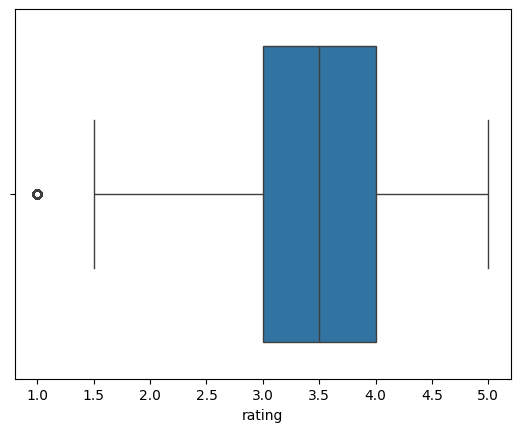

In [69]:
sns.boxplot(data=restaurants_df, x="rating")

#### **There are total 728 unique categories**

In [70]:
explodedDf = restaurants_df.assign(categories=restaurants_df['categories'].str.split(', ')).explode('categories')
categoriesDf = explodedDf['categories'].value_counts().reset_index()
categoriesDf.columns = ['categories', 'count']
categoriesDf

categoriesDf

,categories,count
0,Restaurants,52268
1,Food,15472
2,Nightlife,8723
3,Sandwiches,8366
4,Bars,8337
...,...,...
723,Home Theatre Installation,1
724,Homeowner Association,1
725,Kids Hair Salons,1
726,Calabrian,1


#### **Filter out the categories which are relevant to Restaurants or Food**

In [71]:
# Provided list of categories
categories = [
    "Sandwiches", "American (Traditional)", "Pizza", 
    "Fast Food", "Breakfast & Brunch", "American (New)", "Burgers", "Mexican", 
    "Italian", "Coffee & Tea", "Seafood", "Chinese", "Salad", "Chicken Wings", 
    "Cafes", "Delis", "Bakeries", "Desserts", "Japanese", "Sushi Bars", "Barbeque",
    "Asian Fusion", "Steakhouses", "Diners", "Cocktail Bars", "Mediterranean",
    "Vegetarian", "Ice Cream & Frozen Yogurt", "Soup", "Tacos", "Juice Bars & Smoothies",
    "Southern", "Thai", "Cajun/Creole", "Tex-Mex", "Vegan", "Vietnamese", "Indian",
    "Latin American", "Chicken Shop", "Greek", "Hot Dogs", "Cheesesteaks",
    "Bagels", "Caribbean", "Middle Eastern", "Soul Food", "Ethnic Food",
    "French", "Korean", "Donuts", "Noodles", "Halal", "Wraps", "Spanish",
    "Cuban", "Bubble Tea", "Canadian (New)", "Pakistani", "Ramen", "Irish",
    "Fish & Chips", "Waffles", "Poke", "Hawaiian", "Acai Bowls", "Dim Sum",
    "Modern European", "German", "Fruits & Veggies", "African",
    "Szechuan", "New Mexican Cuisine", "Filipino", "Falafel", "Pretzels",
    "Puerto Rican", "Cupcakes", "Cantonese", "Gelato", "Kebab", "Turkish",
    "Lebanese", "Peruvian", "Taiwanese", "Brazilian", "Donairs", "Hot Pot",
    "British", "Kosher", "Pan Asian", "Colombian", "Ethiopian", "Salvadoran",
    "Patisserie/Cake Shop", "Empanadas", "Moroccan", "Venezuelan", "Laotian",
    "Afghan", "Dominican", "Polish", "Russian", "Persian/Iranian", "Basque",
    "Teppanyaki", "Mongolian", "Arabic", "Argentine", "Portuguese", "Malaysian",
    "Fondue", "Poutineries", "Honduran", "Belgian", "Indonesian", "Himalayan/Nepalese",
    "Haitian", "Burmese", "Macarons", "Ukrainian", "Cambodian", "Trinidadian",
    "Shanghainese", "Egyptian", "Armenian", "Pancakes", "Bangladeshi", "Australian",
    "Scandinavian", "Iberian", "Syrian", "Singaporean", "Uzbek", "Tuscan",
    "South African", "Czech", "Hungarian", "Senegalese", "Nicaraguan", "Austrian",
    "Scottish", "Sardinian", "Georgian", "Sri Lankan"
]

print("Categories Required:",len(categories)) 

Categories Required: 145


In [72]:
filteredDf = explodedDf[explodedDf['categories'].isin(categories)]
filteredDf.head(5)

,business_id,name,city,address,longitude,latitude,rating,review_count,categories
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,935 Race St,-75.155564,39.955505,4.0,80,Bubble Tea
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,935 Race St,-75.155564,39.955505,4.0,80,Coffee & Tea
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,935 Race St,-75.155564,39.955505,4.0,80,Bakeries
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,Ashland City,615 S Main St,-87.058943,36.269593,2.0,6,Burgers
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,Ashland City,615 S Main St,-87.058943,36.269593,2.0,6,Fast Food


In [73]:
def remove_parentheses(text):
    if '(' in text:
        return text.split(' (', 1)[0]
    return text

filteredDf.loc[:, 'categories'] = filteredDf['categories'].apply(remove_parentheses)

#### **Dropping Duplicates**

In [74]:
duplicate_rows = filteredDf[filteredDf.duplicated(subset=['business_id', 'categories'])]
duplicate_rows.shape

(1889, 9)

In [75]:
filteredDf = filteredDf.drop_duplicates(subset=['business_id', 'categories'], keep='first')

In [76]:
# Define the columns to aggregate, excluding the 'categories' column
columns_to_aggregate = filteredDf.columns.difference(['categories', 'business_id'])

# Create a dictionary to store aggregation functions for each column
agg_functions = {col: 'first' for col in columns_to_aggregate}

# Add the aggregation function for the 'categories' column
agg_functions['categories'] = lambda x: ', '.join(x)

# Group by 'business_id' and aggregate using the agg_functions dictionary
cleanDf = filteredDf.groupby('business_id').agg(agg_functions).reset_index()

print("Restaurants after filter:",len(cleanDf))

cleanDf.head(5)

Restaurants after filter: 51246


,business_id,address,city,latitude,longitude,name,rating,review_count,categories
0,---kPU91CF4Lq2-WlRu9Lw,4903 State Rd 54,New Port Richey,28.217288,-82.733344,Frankie's Raw Bar,4.5,24,"Seafood, Latin American"
1,--0iUa4sNDFiZFrAdIWhZQ,6 S White Horse Pike,Clementon,39.817850,-74.993364,Pupuseria Y Restaurant Melba,3.0,14,"Mexican, Ethnic Food"
2,--7PUidqRWpRSpXebiyxTg,9910 108A Avenue,Edmonton,53.554659,-113.493040,Humpty's Family Restaurant,2.0,12,Breakfast & Brunch
3,--8IbOsAAxjKRoYsBFL-PA,4706 Paris Ave,Gentilly,30.006341,-90.074523,The Original Italian Pie,3.0,27,Italian
4,--ZVrH2X2QXBFdCilbirsw,1531 W Wynnewood Rd,Ardmore,39.997299,-75.292207,Chris's Sandwich Shop,4.5,32,"American, Pizza, Sandwiches, Wraps, Delis, Salad"


In [77]:
cleanDf.to_csv('./data/modified_categories.csv', index=False)

## **Visualizing Dataset**

#### **Top 5 Cities with most Restaurants**

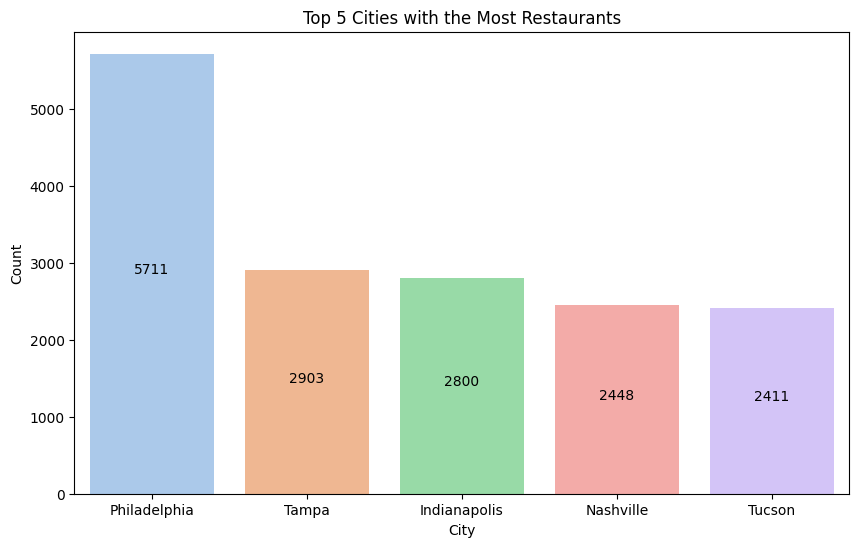

In [78]:
top_5_cities = cleanDf.groupby('city').size().sort_values(ascending=False).head(5)

plt.figure(figsize=(10, 6))

barplot = sns.barplot(x=top_5_cities.index, y=top_5_cities.values, hue=top_5_cities.index, palette="pastel", order=top_5_cities.index)

for index, value in enumerate(top_5_cities.values):
    barplot.text(index, value/2, str(value), ha='center', color='black', fontsize=10)

plt.xlabel('City')
plt.ylabel('Count')
plt.title('Top 5 Cities with the Most Restaurants')

plt.show()


#### **Mean Rating of Restaurants in a City**

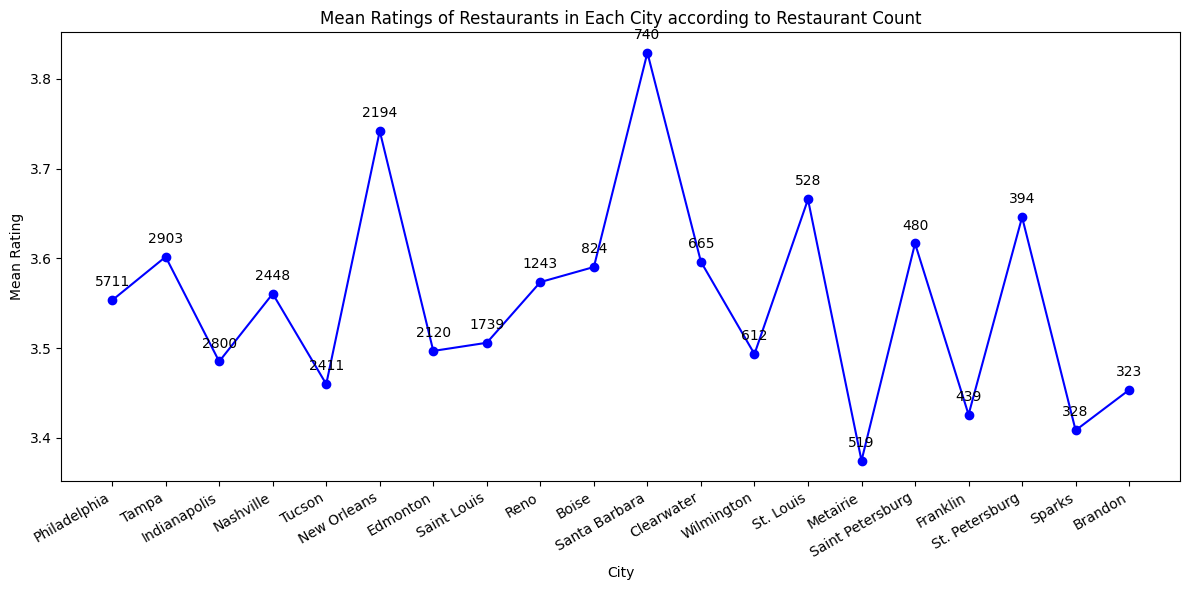

In [79]:
# Group by City and calculate the mean rating
cities_group = cleanDf.groupby('city')
mean_ratings = cities_group['rating'].mean()

city_counts = cities_group.size()
city_stats = pd.DataFrame({'Mean Rating': mean_ratings, 'Count': city_counts})
city_stats_sorted = city_stats.sort_values(by=['Count', 'Mean Rating'], ascending=[False, False]).head(20)

plt.figure(figsize=(12, 6))

plt.plot(city_stats_sorted.index, city_stats_sorted['Mean Rating'], marker='o', linestyle='-', color='b')

for city in city_stats_sorted.index:
    plt.annotate(f'{city_stats_sorted.loc[city, "Count"]}', (city, city_stats_sorted.loc[city, "Mean Rating"]), 
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('City')
plt.ylabel('Mean Rating')
plt.title('Mean Ratings of Restaurants in Each City according to Restaurant Count')

plt.xticks(rotation=30, ha='right')

plt.tight_layout()
plt.show()


#### **Rating Distribution**

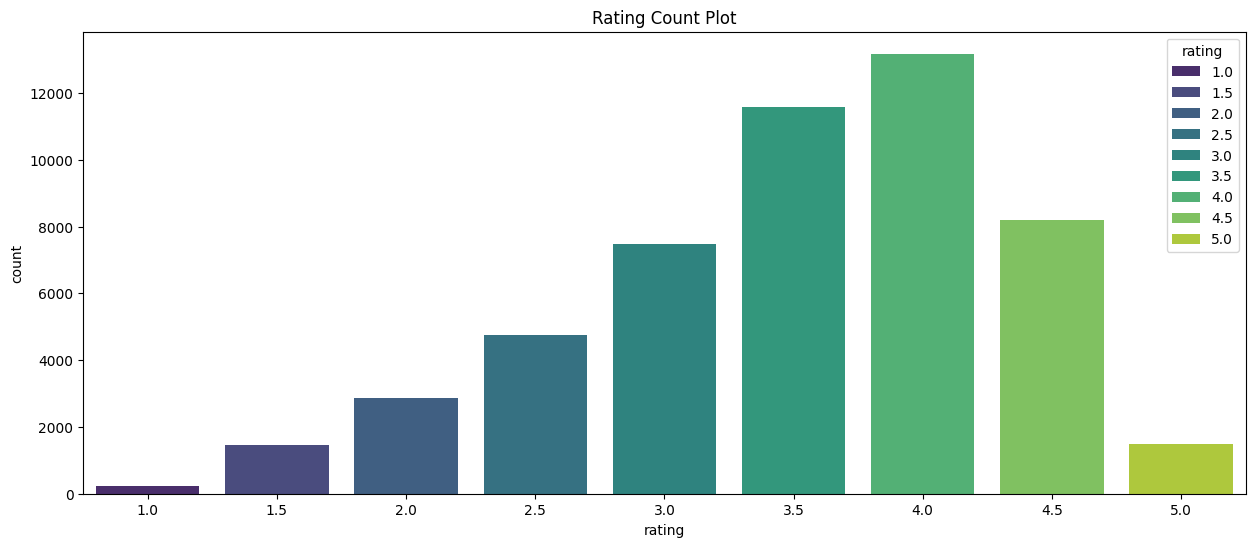

In [80]:
color_palette = sns.color_palette("viridis", n_colors=len(cleanDf['rating'].unique()))

fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(data=cleanDf, x='rating', palette=color_palette, hue='rating')

plt.title('Rating Count Plot')

plt.show()

#### **Top 5 Categories**

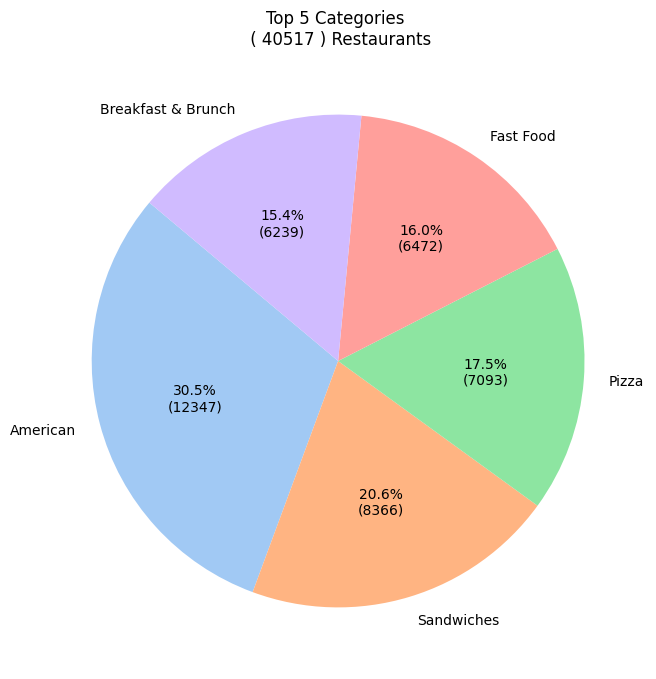

In [81]:
explodedDf = cleanDf.assign(categories=cleanDf['categories'].str.split(', ')).explode('categories')
top_5_categories = explodedDf['categories'].value_counts().reset_index().head(5)
top_5_categories.columns = ['categories', 'count']

total_restaurants = top_5_categories['count'].sum()

plt.figure(figsize=(12, 8))

plt.pie(top_5_categories['count'], labels=top_5_categories['categories'], autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p/100 * top_5_categories['count'].sum()), startangle=140, colors=sns.color_palette("pastel"))

plt.title(f'Top 5 Categories \n ( {total_restaurants} ) Restaurants')
plt.show()

In [82]:
# data_file = open("yelp_academic_dataset_review.json", encoding="utf-8")

# data = []

# for line in data_file:
#   data.append(json.loads(line))

# reviewsDf = pd.DataFrame(data)

In [83]:
# reviewsDf.head(10)

In [84]:
# filtered_reviews_df = reviewsDf[reviewsDf['business_id'] == "Pns2l4eNsfO8kk83dixA6A"]
# filtered_reviews_df